![title](blackfriday.png)


# Advertisements On Black Friday
##### Minh Truong, Yunhan Bai, David Hood 
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------


# Table Of Contents:
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#1">Get Started With Data</a>
        <ul>
            <li> <a href="#library">Libraries</a></li>
            <li><a href="#source">Data Source</a></li>
            <li><a href="#reading">Reading Data</a></li>
        </ul>
    </li>
    <li><a href="#2">Tidying and Modifying Data</a>
        <ul>
            <li> <a href="#missingdata">Handle Missing Data</a></li>
            <li><a href="#melting">Melting Data</a></li>
        </ul>
    </li>
    <li><a href="#3">Exploratory Data Analysis (EDA)</a>
        <ul>
            <li><a href="#4">Gender</a></li>
            <li><a href="#5">Age</a></li>
            <li><a href="#sum">Sum Purchases</a></li>
            <li><a href="#6">Frequency Purchase</a></li>
            <li><a href="#7">Top 5 Selling</a></li>
            <li><a href="#8">Product Category</a></li>
        </ul>
    </li>
    <li><a href="#hypothesis">Hypothesis Testing</a></li>
    <li><a href="#ANOVA">Analysis of Variance</a></li>
    <li><a href="#9">Linear Regression</a></li>
    <li><a href="#10">Logistic Regression</a></li>
    <li><a href="#conclusion">Conclusion</a></li>
</ul>


# <section id="intro">Introduction</section>
<br>
The <mark>first recorded use</mark> of the term “Black Friday” was applied not to holiday shopping but to <a href="https://www.history.com/news/whats-the-real-history-of-black-friday">financial crisis</a>: specifically, the crash of the U.S. gold market on September 24, 1869. Two notoriously ruthless Wall Street financiers, Jay Gould and Jim Fisk, worked together to buy up as much as they could of the nation’s gold, hoping to drive the price sky-high and sell it for astonishing profits. On that Friday in September, the conspiracy finally unraveled, sending the stock market into free-fall and bankrupting everyone from Wall Street barons to farmers.
<br><br>
<mark>In recent years</mark>, another myth has surfaced that gives a particularly ugly twist to the tradition, claiming that back in the 1800s Southern plantation owners could buy slaves at a discount on the day after Thanksgiving. Though this version of Black Friday’s roots has understandably led some to call for a boycott of the retail holiday, it has no basis in fact.
<br><br>
The <strong>"Black Friday"</strong> we know today is a much happier occasion then the two above... <br>

<img src="Crazybf2.png" width="600" height="300"/>

<br>though, maybe just as violent. After the pumpkin pie, families all over America make there way to their local retailers to spend absurd amounts of money for the upcoming holiday season.
<br><br>
In this tutorial, our <mark>goal</mark> is to advertise the right products to the right people. As an advertising agency, our strategy is to learn different behaviors of customers on Black Friday to see what they really like and what they would like to buy on Black Friday. Also, we want to learn from the past purchases to recognize the pattern and likelihood in a certain group of people in order to increase the profit on Black Friday. Moreover, we would like to know which product categories are purchased the most and by which groups of people has bought the most for that particular product category. 

# <section id="1"> Getting Started with the Data</section>

# <section id="library">Importing Libraries</section> 
We make use of Python 3 along with a few imported libraries: <a href="http://pandas.pydata.org/pandas-docs/stable/">pandas</a>, <a href="http://www.numpy.org/">numpy</a>, <a href="https://matplotlib.org/tutorials/index.html">matplotlib</a>, <a href="https://scikit-learn.org/stable/">scikit-learn</a>, <a href="https://seaborn.pydata.org/">seaborn</a>, and more.

In [1]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Necessary libraries and imports to complete this tutorial
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import f
from statsmodels.formula.api import ols
from sklearn import linear_model, preprocessing, model_selection
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D

C:\Users\truon\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# <section id="source">Data Source</section>
Dataset of 550 000 observations about the black Friday in a retail store, it contains different kinds of variables either numerical or categorical. It contains missing values.
<br><br> Kaggle dataset <a href="https://www.kaggle.com/mehdidag/black-friday">here</a>

# <section id="reading">Reading the data</section>

In [2]:
blackfriday = pd.read_csv("blackfriday.csv")
#Making Mean_age so for graphing in later sections
blackfriday['Mean_age'] = blackfriday['Age'].map({'0-17': 8.5, '18-25': 21.5,'26-35': 30.5, '36-45': 40.5,'46-50': 48, '51-55': 53, '55+': 67.5})
#Modify the "Stay_In_Current_City_Years" column, so assume that anyone that live more than 4 years is just 4 years.
blackfriday['Stay_In_Current_City_Years'] = blackfriday['Stay_In_Current_City_Years'].map({'0': 0, '1': 1, '2': 2, '3': 3,'4+': 4})
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,NaN,NaN,7969,67.5


In the above dataset, there are 12 columns in total. We have: <br>
Column 1: User_ID <br>
Column 2: Product_ID  <br>
Column 3: Gender (Male and Female) <br>
Column 4: Age (Age in bins) <br>
Column 5: Occupation <br>
Column 6: City_Category (A, B, C) <br>
Column 7: Stay_In_Current_City_Years (Number of years stay in current city) <br>
Column 8: Marital_Status (0 for single, 1 for married) <br>
Column 9: Product_Category_1 <br>
Column 10: Product_Category_2 <br>
Column 11: Product_Category_3 <br>
Column 12: Purchase (Purchase amount in Dollars) <br>
Column 13: Mean_Age (mean of the age bins)<br>
<br>
A product can belong to many different categories.<br>

Display some basic statistic about the dataset. Since summary statistics are used in the pandas describe() method, only the columns with quantitative data are displayed. There are 537577 purchases made in the dataset.

In [3]:
blackfriday.describe()

,User_ID,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
count,5.375770e+05,537577.00000,537577.000000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000,537577.000000
mean,1.002992e+06,8.08271,1.859458,0.408797,5.295546,9.842144,12.669840,9333.859853,34.725908
std,1.714393e+03,6.52412,1.289828,0.491612,3.750701,5.087259,4.124341,4981.022133,12.004781
min,1.000001e+06,0.00000,0.000000,0.000000,1.000000,2.000000,3.000000,185.000000,8.500000
25%,1.001495e+06,2.00000,1.000000,0.000000,1.000000,5.000000,9.000000,5866.000000,30.500000
50%,1.003031e+06,7.00000,2.000000,0.000000,5.000000,9.000000,14.000000,8062.000000,30.500000
75%,1.004417e+06,14.00000,3.000000,1.000000,8.000000,15.000000,16.000000,12073.000000,40.500000
max,1.006040e+06,20.00000,4.000000,1.000000,18.000000,18.000000,18.000000,23961.000000,67.500000


# <section id="2">Tidying and modifying the data</section>

<b> In tidy data: </b>
<br> 1. Each variable forms a column.
<br> 2. Each observation forms a row.
<br> 3. Each type of observational unit forms a table.

### <section id="missingdata">Handling missing data</section>
In our dataset the three columns Product_Category_1,Product_Category_2, and Product_Category_3 represent all the  categories that the puchesed product belongs to. Most products belong to three categories, but some belong to two or less. These columns will have NaN as the value. This will make things difficult when we try to make a category table in the next step. Therefore, we are going to replace NaN with 0 to let to convey that product does not belong to any more categories. 

In [4]:
blackfriday = blackfriday.fillna(0)
blackfriday.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Mean_age
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,8.5
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,8.5
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,8.5
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,8.5
4,1000002,P00285442,M,55+,16,C,4,0,8,0.0,0.0,7969,67.5


### <section id="melting">Melting Product Category Table</section>
Another step in tidying data is to remove variables from column names. <br>For our dataframe, Product_Category_1, Product_Category_2, and Product_Category_3 should be melted into one column.<br>To keep the original dataframe clear and have fewer repeated information, we will create a new dataframe to store Product_Category seperately. <br>The Category of a product can be looked up with its Product_ID in the new dataframe. <br> Several columns are retained for lookups in future analysis.

In [5]:
# Create a seperate dataframe to store category infomation
category_table = blackfriday[['Product_ID', 'Age', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
# Drop Product_Category columns from the original dataframe for neatness
blackfriday = blackfriday.drop(['Product_Category_1','Product_Category_2', 'Product_Category_3'], axis=1)

# Melt Product_Category columns in to one
category_table = pd.melt(category_table, id_vars=['Product_ID', 'Age'], value_vars=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'])
# Drop any row with value equals to 0 (no category)
category_table = category_table[category_table.value != 0]   
# Drop variable column
category_table = category_table.drop(['variable'], axis=1)
# Rename value column to Product_Category
category_table = category_table.rename(index=str, columns={"value": "Product_Category"})
category_table.head()

,Product_ID,Age,Product_Category
0,P00069042,0-17,3.0
1,P00248942,0-17,1.0
2,P00087842,0-17,12.0
3,P00085442,0-17,12.0
4,P00285442,55+,8.0


For More information about tidying data, you can click this <a href="http://vita.had.co.nz/papers/tidy-data.html">link</a>

# <section id="3">Exploratory Data Analysis (EDA)</section>
#### Four types of EDA
- Univariate non-graphical
- Multivariate non-graphical
- Univariate graphical
- Multivariate graphical

#### Advantages of EDA:
- Detection of mistakes
- Checking of assumptions
- Preliminary selection of appropriate models
- Determining relationships among the explanatory variables
- Assessing the direction and rough size of relationships between explanatory and outcome variables

# <section id="4">Gender</section>

In [6]:
purchase_by_user = blackfriday.groupby(['User_ID', 'Gender']).agg({'Purchase': np.sum})
purchase_by_user.reset_index(inplace=True)
purchase_by_user.head()

,User_ID,Gender,Purchase
0,1000001,F,333481
1,1000002,M,810353
2,1000003,M,341635
3,1000004,M,205987
4,1000005,M,821001


It is often believed that women spend more than men on Black Friday. To test this myth we made the graph below to observe the total spending of both genders. As the following graph shows, we can see a large difference between male and female spending. However the results are the opposite of what we were lead to expect. The graph below shows that women spend about a third of the amount men do on Black Friday. Myth busted!

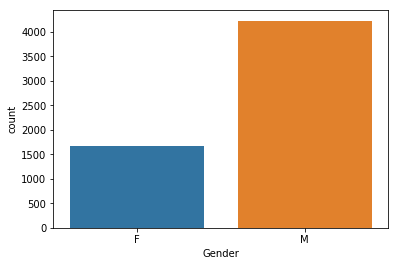

In [7]:
ax = sns.countplot(purchase_by_user['Gender'])

This gender split is really helpful for retailers and advertising agencies. With this information, retailers could modify their store layout, and product selection to appeal to their larger male consumer base. Advertising agency might want to choose different strategies to advertise products and the whole Black Friday shopping experience based on the gender proportion of their shoppers. They could further appeal to men bye marketing the Black Friday experience in ways that solicit to them. For example, Walmart could hire <a href="https://en.wikipedia.org/wiki/Shaquille_O%27Neal"> Shaquille O'Neal</a> to appear in an ad, boxing out other customers while he gets the products he wants.
<br><br>
However this is just the count of shoppers based on gender. For further investigation, we should look at the average amount, in dollars, spent by each gender.

In [8]:
male_spending = purchase_by_user[purchase_by_user.Gender=='M'].mean()

female_spending = purchase_by_user[purchase_by_user.Gender=='F'].mean()

print("The average of spending money by male on Black Friday is $" + str(male_spending.Purchase))

print("The average of spending money by female on Black Friday is $" + str(female_spending.Purchase))


The average of spending money by male on Black Friday is $911963.1614201183
The average of spending money by female on Black Friday is $699054.0342136854


Now, let's visualize the result:

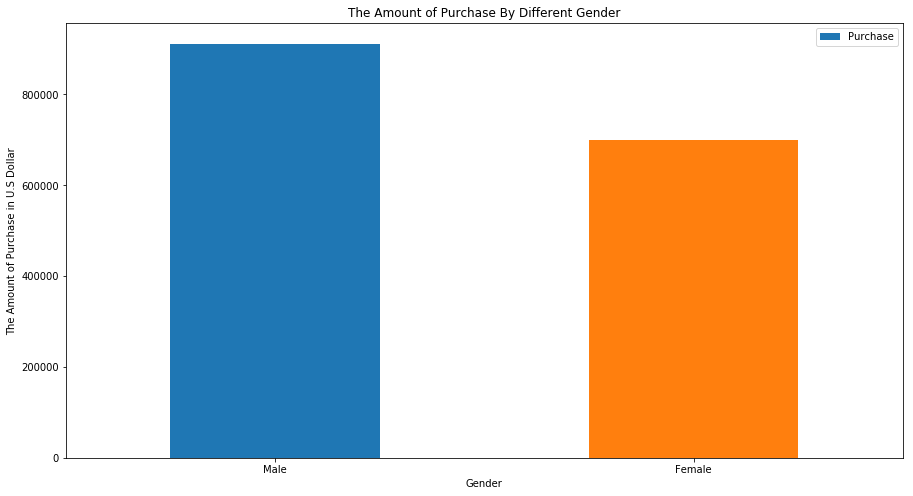

In [9]:
data = {'Gender':["Male", "Female"], 'Purchase': [male_spending.Purchase, female_spending.Purchase]}
avg_spend_by_gender = pd.DataFrame(data=data)
ax = avg_spend_by_gender.plot.bar(x='Gender', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase By Different Gender")
plt.xlabel("Gender")
plt.ylabel("The Amount of Purchase in U.S Dollar")
plt.show()

This is a very interesting observation. It seems women are spending almost as much, on average, as male shoppers even though there are far less of them making purchases. From this observation, we note that the number of males and females play an important role here. Women are only spending about $250,000 less than men even though there are far less of them shopping. From these two graphs we can conclude there are much more men buying on Black Friday than women. However on average women spend much more.

#  <section id="5">Age</section>

Creating an ad to appeal to a certain age group is very important. One reason is that different age groups consume different media. If I had a product that sold well to people over 55 but not well at all to younger ages, it would be a very bad idea to create ads on <a href="https://help.instagram.com/424737657584573Instagram">Instagram</a> for it. We don't want customers to see ads for a product that they are not interested in. If we advertise the wrong products to a group, it could also be other problems. There might be a critic from people who are not supposed to see it. Retailers could also be upset that they spent money on a non profitable group. In conclusion, it is very important that we analyze the data by age group.

Now, let's view how a customer in different groups of age spend money on Black Friday. 

In [10]:
groups = blackfriday.groupby(['User_ID', 'Age', 'Mean_age']).agg({'Purchase': np.sum}).reset_index()
#0-17
print('group 0-17 total purchase')
display(groups[groups.Mean_age == 8.5].head())
#18-25
print('group 18-25 total purchase')
display(groups[groups.Mean_age == 21.5].head())
#26-35
print('group 26-35 total purchase')
display(groups[groups.Mean_age == 30.5].head())
#36-45
print('group 36-45 total purchase')
display(groups[groups.Mean_age == 40.5].head())
#46-50
print('group 46-50 total purchase')
display(groups[groups.Mean_age == 48].head())
#51-55
print('group 51-55 total purchase')
display(groups[groups.Mean_age == 53].head())
#55+
print('group 55+ total purchase')
display(groups[groups.Mean_age == 67.5].head())

group 0-17 total purchase


,User_ID,Age,Mean_age,Purchase
0,1000001,0-17,8.5,333481
18,1000019,0-17,8.5,1457938
48,1000051,0-17,8.5,200772
72,1000075,0-17,8.5,1035228
83,1000086,0-17,8.5,294050


group 18-25 total purchase


,User_ID,Age,Mean_age,Purchase
17,1000018,18-25,21.5,1978675
20,1000021,18-25,21.5,126744
21,1000022,18-25,21.5,1279678
24,1000025,18-25,21.5,534215
33,1000034,18-25,21.5,807747


group 26-35 total purchase


,User_ID,Age,Mean_age,Purchase
2,1000003,26-35,30.5,341635
4,1000005,26-35,30.5,821001
7,1000008,26-35,30.5,796545
8,1000009,26-35,30.5,593960
10,1000011,26-35,30.5,556902


group 36-45 total purchase


,User_ID,Age,Mean_age,Purchase
6,1000007,36-45,40.5,234427
9,1000010,36-45,40.5,2169486
13,1000014,36-45,40.5,127629
15,1000016,36-45,40.5,150428
22,1000023,36-45,40.5,1670998


group 46-50 total purchase


,User_ID,Age,Mean_age,Purchase
3,1000004,46-50,48.0,205987
12,1000013,46-50,48.0,713927
32,1000033,46-50,48.0,1940043
34,1000035,46-50,48.0,821303
41,1000044,46-50,48.0,1180380


group 51-55 total purchase


,User_ID,Age,Mean_age,Purchase
5,1000006,51-55,53.0,379450
16,1000017,51-55,53.0,1425501
51,1000054,51-55,53.0,187201
56,1000059,51-55,53.0,980068
57,1000060,51-55,53.0,279980


group 55+ total purchase


,User_ID,Age,Mean_age,Purchase
1,1000002,55+,67.5,810353
30,1000031,55+,67.5,496154
77,1000080,55+,67.5,339119
86,1000089,55+,67.5,112226
87,1000090,55+,67.5,1310621


### Graphing the amount of purchase by different groups of age

Text(0,0.5,'The Amount of Purchase in U.S Dollar')

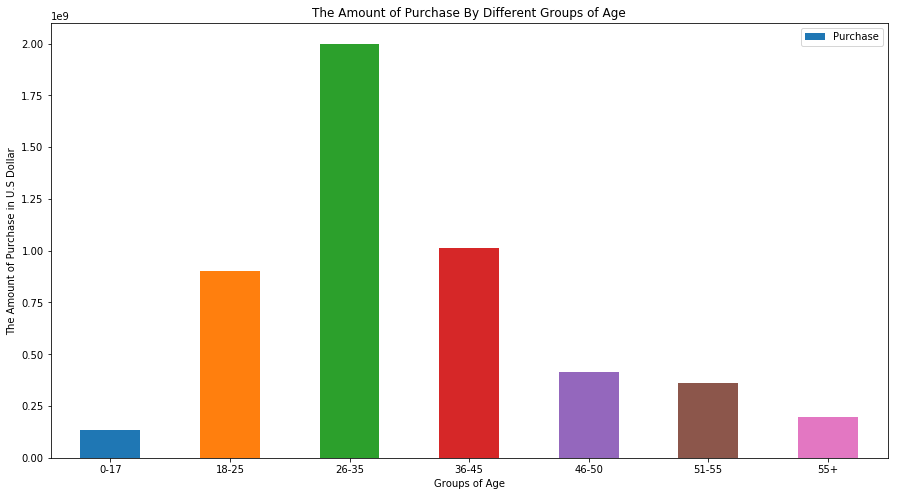

In [11]:
groups = blackfriday.groupby(['Age']).agg({'Purchase': np.sum}).reset_index()
ax = groups.plot.bar(x='Age', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase By Different Groups of Age")
plt.xlabel("Groups of Age")
plt.ylabel("The Amount of Purchase in U.S Dollar")

As we see above, customers with age between 26 and 35 spend the most on Black Friday. This is useful information if we want to target this group to advertise new products, and blast them with ads reminding them when Black Friday is approaching. It's also apparent that we should not focus on the elderly. Putting commercials television stations frequently viewed by the elderly would not be a good idea. This is because they are highly likely to spend more money than the other groups to buy new products. And people from group of age 0-17 or 55+ spend less money than other. We should limit the ads over these groups because it will cost money if this group is not active shoppers.<br><br>For a more in depth read about age groups and how to maket to them please click the following <a href="https://martech.zone/what-is-generational-marketing/to">link</a> to an artical on generational marketing

# <section id="sum">Sum of purchases for each product</section>

At the end of the day, a retailer would like to know which product has been purchased the most and which product has been purchased the least. It would help a retailer know which items to stock up on, and which items to have less of when Black Friday rolls around. Since we have so many products in our table, we won't be able to graph them all. So we will graph the top 100 purchased products and the bottom 100 purchased product. Then, we can visualize the sum of purchase for the top and bottom 100 products.

First, let's compute the sum of a purchase for a product

In [12]:
total_purchase_of_a_product = blackfriday.groupby('Product_ID').agg({'Purchase': np.sum})
total_purchase_of_a_product.reset_index(inplace=True)
total_purchase_of_a_product['Product_ID'] = total_purchase_of_a_product['Product_ID'].str.replace('P', '').astype(int)
total_purchase_of_a_product.sort_values(by=['Purchase'], ascending=False, inplace=True)
total_purchase_of_a_product.head()

,Product_ID,Purchase
249,25442,27532426
1014,110742,26382569
2441,255842,24652442
1743,184942,24060871
581,59442,23948299


Now, let's visualize our data:

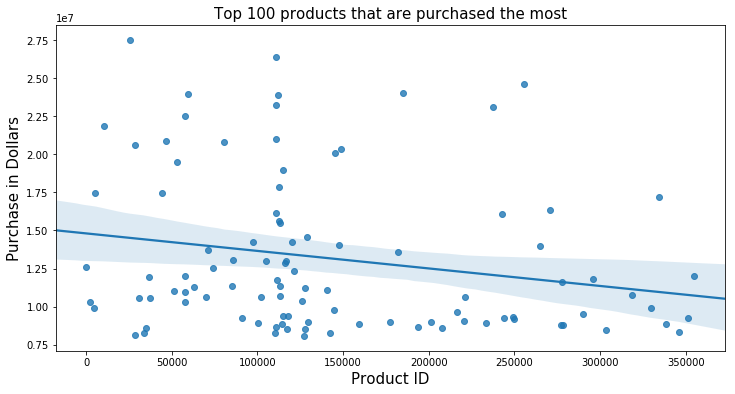

In [13]:
top_100 = total_purchase_of_a_product.head(100)
ax = sns.regplot(x='Product_ID', y='Purchase', data=top_100)

ax.figure.set_size_inches(12, 6)
title = "Top 100 products that are purchased the most"
plt.title(title, fontsize=15)
plt.xlabel('Product ID', fontsize=15)
plt.ylabel('Purchase in Dollars', fontsize=15)
plt.show()

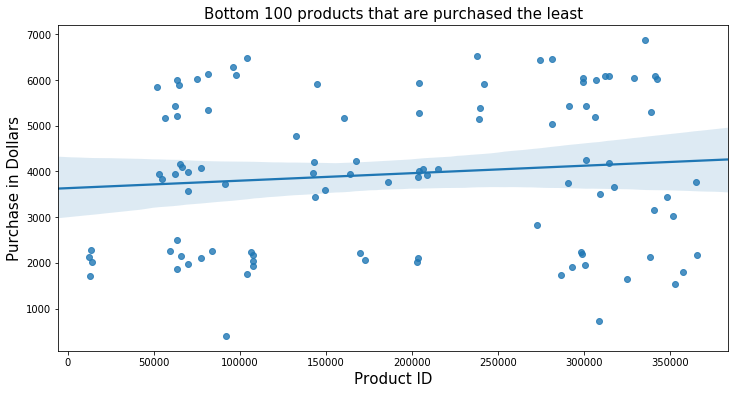

In [14]:
bot_100 = total_purchase_of_a_product.tail(100)
ax = sns.regplot(x='Product_ID', y='Purchase', data=bot_100)

ax.figure.set_size_inches(12, 6)
title = "Bottom 100 products that are purchased the least"
plt.title(title, fontsize=15)
plt.xlabel('Product ID', fontsize=15)
plt.ylabel('Purchase in Dollars', fontsize=15)
plt.show()

This information is highly valuable especially around this time of year. The best selling Black Friday product are most likely intended to be presents for the holiday season. Retailers should stock up on the top items so they can sell to the holiday buyers.

# <section id="6"> Frequency Purchase </section>

There are several ways to measure purchase frequency on its own. However, we need to measure whether purchase frequency has increased as a result of the community. For this, we can reuse much of the same process to measure changes in spending.

Frequency of purchase is the number of orders placed by a customer over a defined period of time (typically one month or one year). Greater purchase frequently typically implies higher profitability. An online community might encourage people to use the product more and thus purchase more frequently, or use the product more often and have to replace it most often.

Same as the sum of products, we want to know the top and bottom 100 products. 

First, compute the frequency of a product that is purchased within a group

In [15]:
freq_purchase =  blackfriday.groupby(['Product_ID']).Product_ID.count().to_frame() # counting the frequency for each product
freq_purchase['Freq'] = freq_purchase.Product_ID #create a new column named "Freq"
freq_purchase = freq_purchase.drop(columns=['Product_ID'], axis=1) 
freq_purchase.reset_index(level=0, inplace=True)
freq_purchase['Product_ID'] = freq_purchase['Product_ID'].str.replace('P', '').astype(int)
freq_purchase.sort_values(by=['Freq'], ascending=False, inplace=True)
freq_purchase.head()

,Product_ID,Freq
2534,265242,1858
1014,110742,1591
249,25442,1586
1028,112142,1539
565,57642,1430


Then, merge the two tables: freq_purchase and total_purchase_of_a_product

In [16]:
#Using outer join to merge the two tables together.
freq_purchase = freq_purchase.merge(total_purchase_of_a_product, left_on='Product_ID', right_on='Product_ID', how='outer')
freq_purchase.head()

,Product_ID,Freq,Purchase
0,265242,1858,13983325
1,110742,1591,26382569
2,25442,1586,27532426
3,112142,1539,23882624
4,57642,1430,22493690


### Graphing Frequency Distribution of Top and Bottom 100 Purchased Products

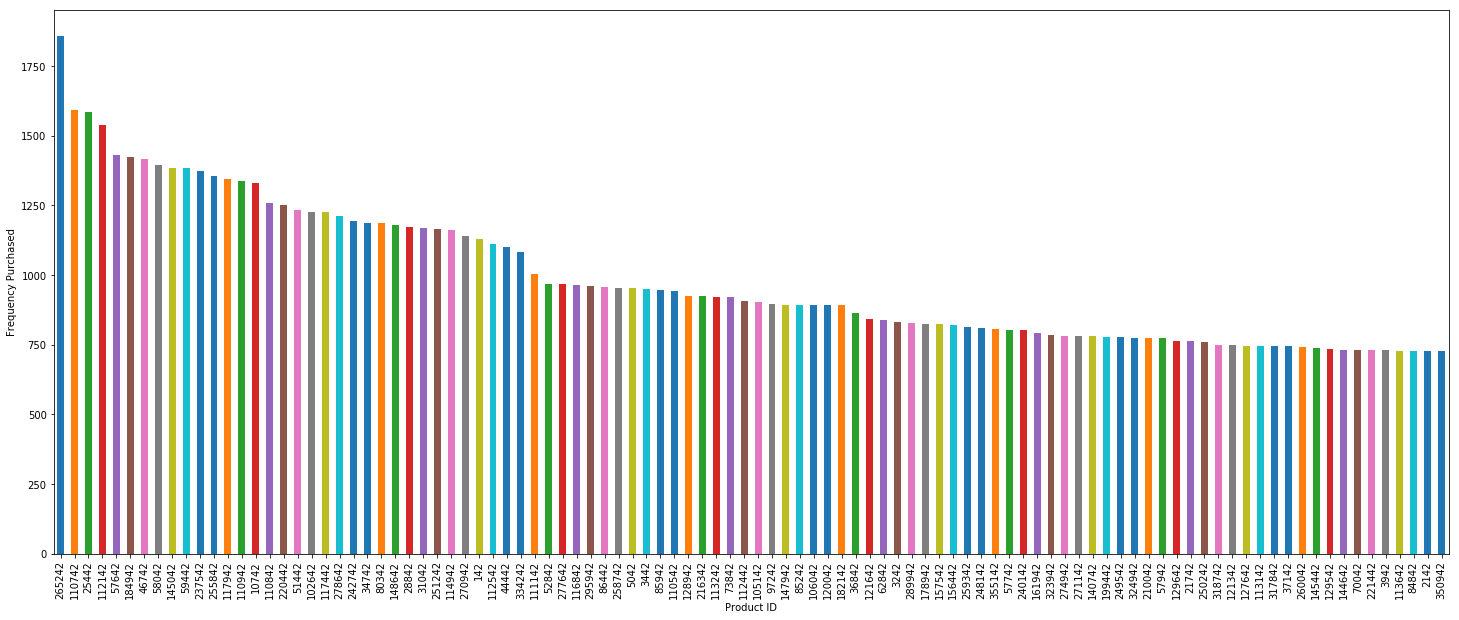

In [17]:
top_100 = freq_purchase.head(100)

#Using bar plot to describe the frequency of a product is purchased.
ax = top_100.plot.bar(x='Product_ID', y='Freq', figsize=(25, 10))
ax.set_xlabel("Product ID") #Label the x-axis
ax.set_ylabel("Frequency Purchased") #label the y-axis
ax.get_legend().remove()

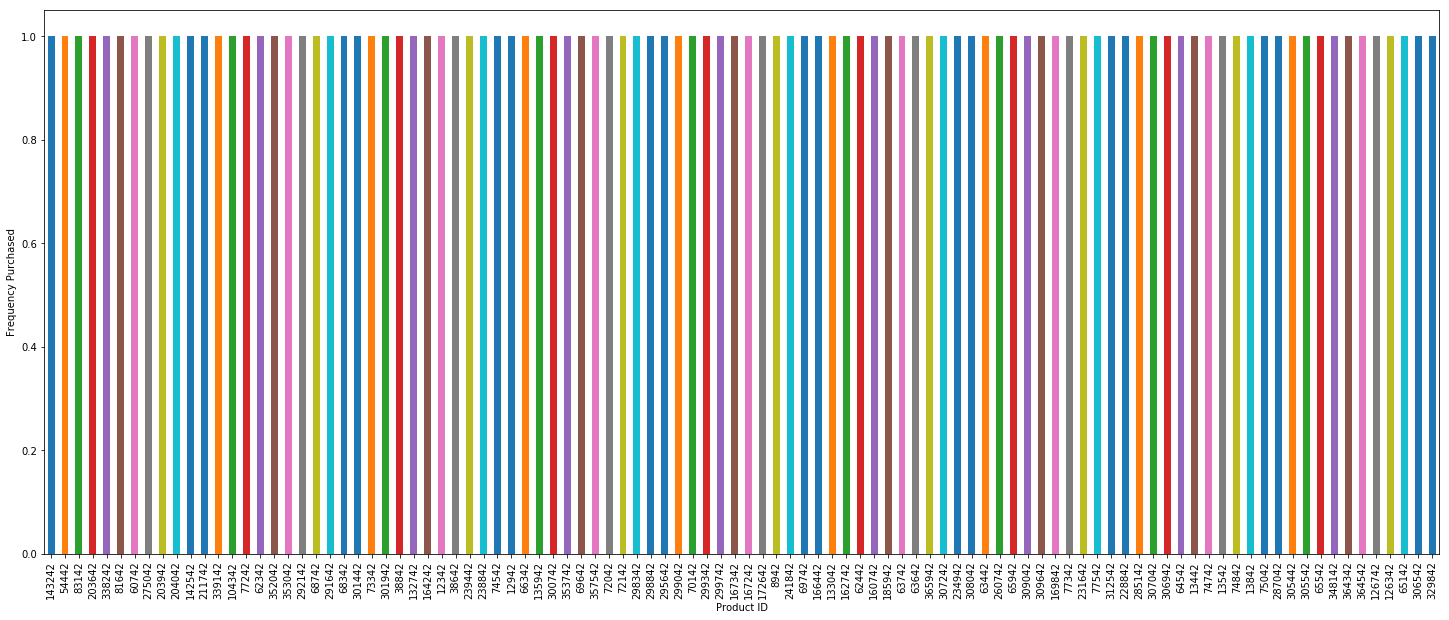

In [18]:
bot_100 = freq_purchase.tail(100)

#Using bar plot to describe the frequency of a product is purchased.
ax = bot_100.plot.bar(x='Product_ID', y='Freq', figsize=(25, 10))
ax.set_xlabel("Product ID") #Label the x-axis
ax.set_ylabel("Frequency Purchased") #label the y-axis
ax.get_legend().remove()

# City Category

### Graphing the amount of purchase from different city category

Text(0,0.5,'The Amount of Purchase in U.S Dollar')

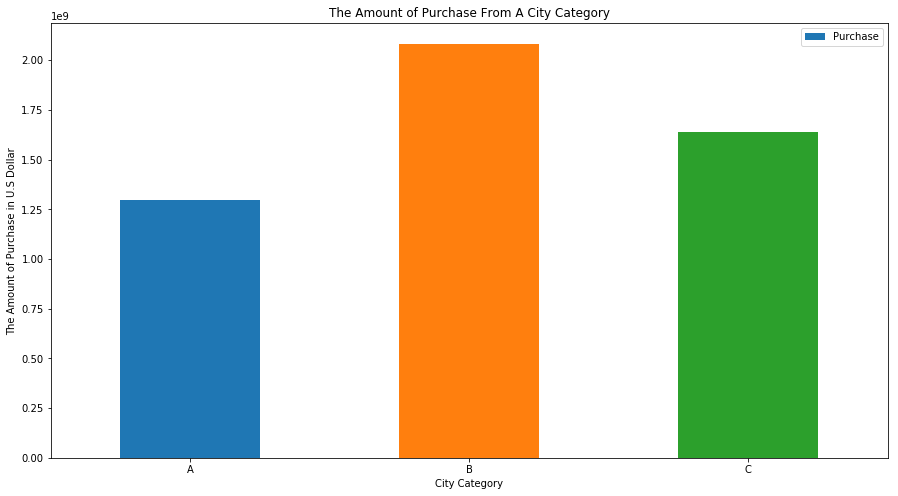

In [19]:
groups = blackfriday.groupby(['City_Category']).agg({'Purchase': np.sum}).reset_index()
ax = groups.plot.bar(x='City_Category', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase From A City Category")
plt.xlabel("City Category")
plt.ylabel("The Amount of Purchase in U.S Dollar")

The graph above represents the amount spent in city A, B, and C.

### Graphing Frequency Distribution of Product Categories

Text(0,0.5,'Counts')

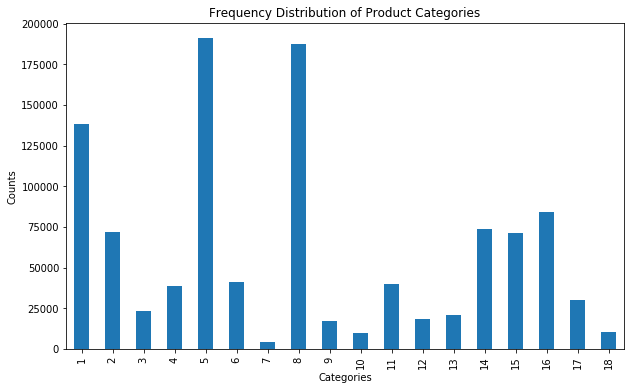

In [20]:
# Create a frequency table of Product_Category from category_table
freq_category = category_table.groupby('Product_Category').count()
freq_category = freq_category.drop(['Age'], axis=1)
# Plotting the distribution with bar chart
ax=freq_category.plot(kind='bar', legend=False, figsize=(10,6))
ax.set_xticklabels(range(1,19))
ax.set_title("Frequency Distribution of Product Categories")
ax.set_xlabel("Categories")
ax.set_ylabel("Counts")

This graph shows the frequency at which each item category is bought.

# <section id="7">Top 5 selling products</section>

### Find The Target audiance for top 5 best selling products

In [21]:
freq_purchase_by_PID =  blackfriday.groupby(['Product_ID']).Product_ID.count().to_frame() # counting the frequency for each product
freq_purchase_by_PID['Freq'] = freq_purchase_by_PID.Product_ID #create a new column named "Freq"
freq_purchase_by_PID = freq_purchase_by_PID.drop(columns=['Product_ID'], axis=1) 
freq_purchase_by_PID.reset_index(level=0, inplace=True)
top_5 = freq_purchase_by_PID.sort_values(by=['Freq'], ascending=False).head()
top_5

,Product_ID,Freq
2534,P00265242,1858
1014,P00110742,1591
249,P00025442,1586
1028,P00112142,1539
565,P00057642,1430


It looks like our best 5 selling products are:
<ul>
    <li>P00265242 = 1858</li>
    <li>P00110742 = 1591</li>
    <li>P00025442 = 1586</li>
    <li>P00112142 = 1539</li>
    <li>P00057642 = 1430</li>
</ul>

Having found the top selling products, one thing we could be interested in is finding the target occupation to advertise/appeal to when considering these five products.

Text(0,0.5,'The Amount of Purchase in U.S Dollar')

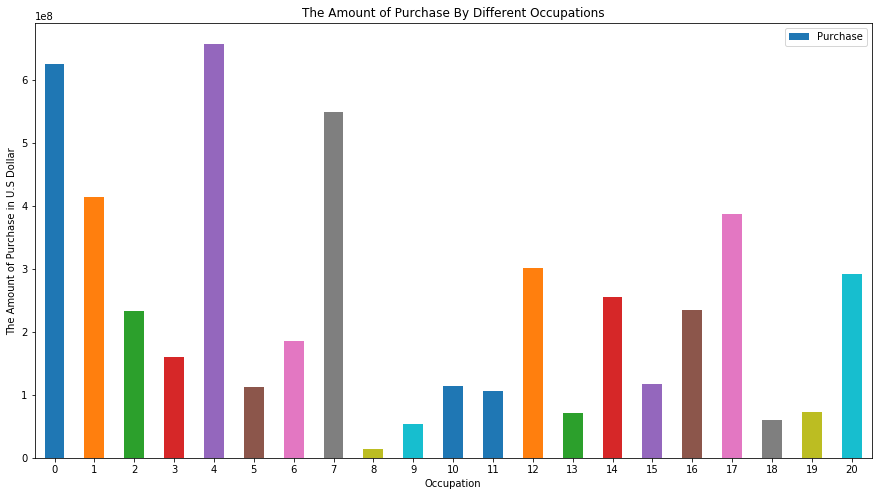

In [22]:
#Most sold product
top_5 = blackfriday.loc[blackfriday['Product_ID'].isin(['P00265242','P00110742','P00025442','P00112142','P00057642'])]
groups = blackfriday.groupby(['Occupation']).agg({'Purchase': np.sum}).reset_index()
ax = groups.plot.bar(x='Occupation', y='Purchase', rot=0)
ax.figure.set_size_inches(15, 8)
plt.title("The Amount of Purchase By Different Occupations")
plt.xlabel("Occupation")
plt.ylabel("The Amount of Purchase in U.S Dollar")

It would seem that Occupation 4 and 0 are the top buyers of our products. Say that these two occupations are business related. We could use this information to put an ad over these products with a person in a business suit enjoying the product.

We can see from our previous graphs that the top selling 
product is P00265242. The top consumer city is city B. Now lets try to advertise the best selling product in the 
largest consumer city.
Our goal is to make an ad that appeals to the largest consumer group of product P00265242 in city B.
When making the ad we need to take into account the target age group, the taget gender, and the target marital status 

Text(0,0.5,'Amount of Product P00265242 Purchased')

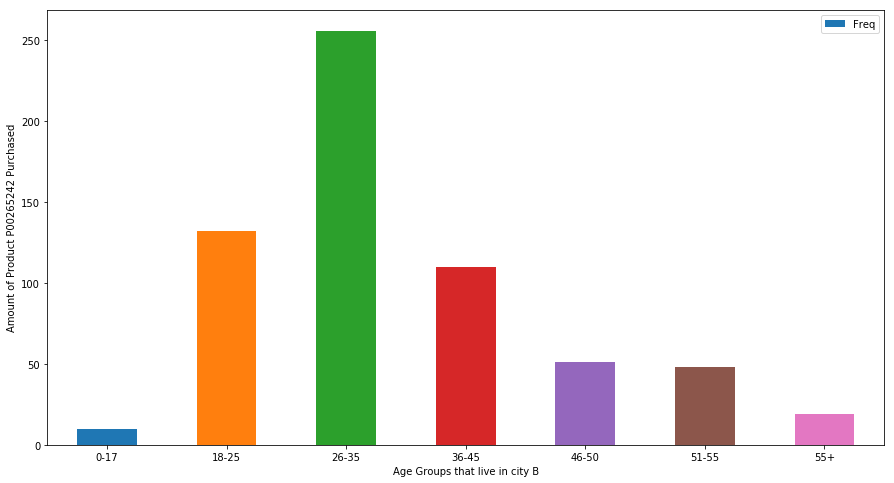

In [23]:
#Highest spending city
city_B = blackfriday.loc[blackfriday["City_Category"] == "B"]
#Most sold product
city_B_best_seller = city_B.loc[city_B['Product_ID']=='P00265242']
#city_b_cat_5 = pd.merge(city_A,catagory_5, on='Product_ID', how='inner')
freq_purchase_by_age =  city_B_best_seller.groupby(['Age']).Product_ID.count().to_frame()
freq_purchase_by_age['Freq'] = freq_purchase_by_age.Product_ID #create a new column named "Freq"
freq_purchase_by_age = freq_purchase_by_age.drop(columns=['Product_ID'], axis=1) 
freq_purchase_by_age.reset_index(level=0, inplace=True)
ax = freq_purchase_by_age.plot.bar(x='Age', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Age Groups that live in city B")
plt.ylabel("Amount of Product P00265242 Purchased")

Unsuprisingly, based on graphs above, we can see that the target age group should be ages from 26 to 35. Now lets see how many of our taget
age are male or female.

Text(0,0.5,'Amount of Product P00265242 Purchased')

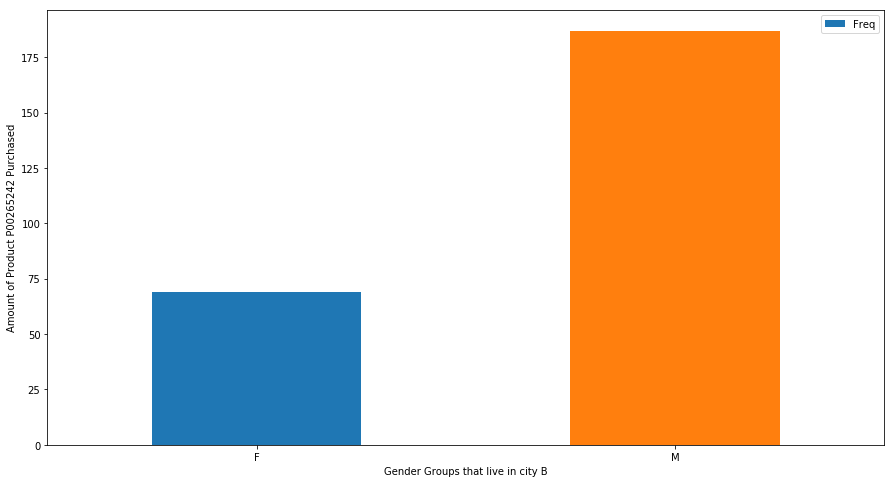

In [24]:
target = city_B_best_seller.loc[city_B_best_seller['Age']=='26-35']
freq_purchase_by_gender =  target.groupby(['Gender']).Product_ID.count().to_frame()
freq_purchase_by_gender['Freq'] = freq_purchase_by_gender.Product_ID #create a new column named "Freq"
freq_purchase_by_gender = freq_purchase_by_gender.drop(columns=['Product_ID'], axis=1) 
freq_purchase_by_gender.reset_index(level=0, inplace=True)
ax = freq_purchase_by_gender.plot.bar(x='Gender', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Gender Groups that live in city B")
plt.ylabel("Amount of Product P00265242 Purchased")

We can now narrow our target group to 26-35 year old men. Lets see if the taget group is single or not

Text(0,0.5,'Amount of Product P00265242 Purchased')

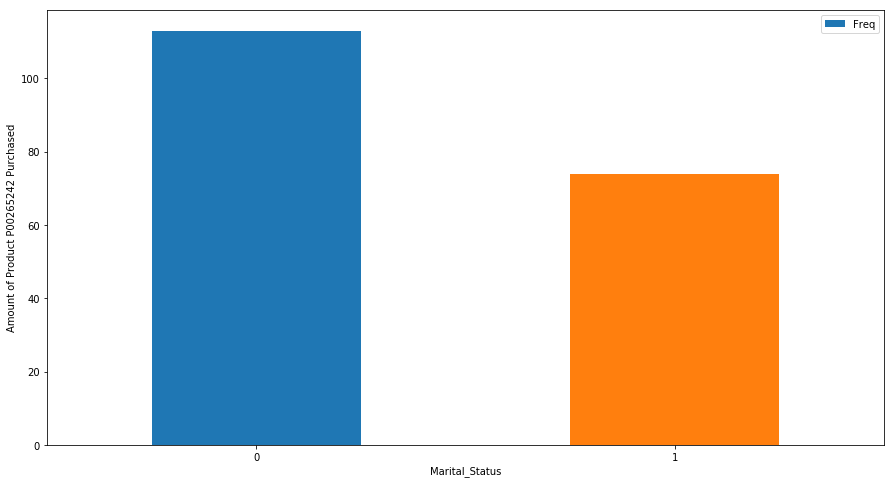

In [25]:
target = target.loc[target['Gender']=='M']
freq_purchase_by_status =  target.groupby(['Marital_Status']).Product_ID.count().to_frame()
freq_purchase_by_status['Freq'] = freq_purchase_by_status.Product_ID #create a new column named "Freq"
freq_purchase_by_status = freq_purchase_by_status.drop(columns=['Product_ID'], axis=1) 
freq_purchase_by_status.reset_index(level=0, inplace=True)
ax = freq_purchase_by_status.plot.bar(x='Marital_Status', y='Freq', rot=0)
ax.figure.set_size_inches(15, 8)
plt.xlabel("Marital_Status")
plt.ylabel("Amount of Product P00265242 Purchased")

As an advertising company we should focus on creating an ad that will appeal to single men around the age of 25-36 who live in city B.

Let's continue with the previous scenario. Suppose this time we want to find a target age group for each product category.  

# <section id="8"> Product Category </section>

### Graphing percentage of purchase from each age group by category 

#### Find the target audiance for each product category

In [26]:
# Obtain a list of age groups
age_column = blackfriday.Age.unique()
age_column.sort()
# Create a new dataframe for counting
age_count = pd.DataFrame(index=range(1,19), columns=age_column)

# Obtain total purchases made by each age group for every category
for cate_num, cate_group in category_table.groupby('Product_Category'):
    count = cate_group.groupby('Age').count()
    for age_group, row in count.iterrows():
        age_count.loc[cate_num, age_group] = count.loc[age_group, 'Product_Category']

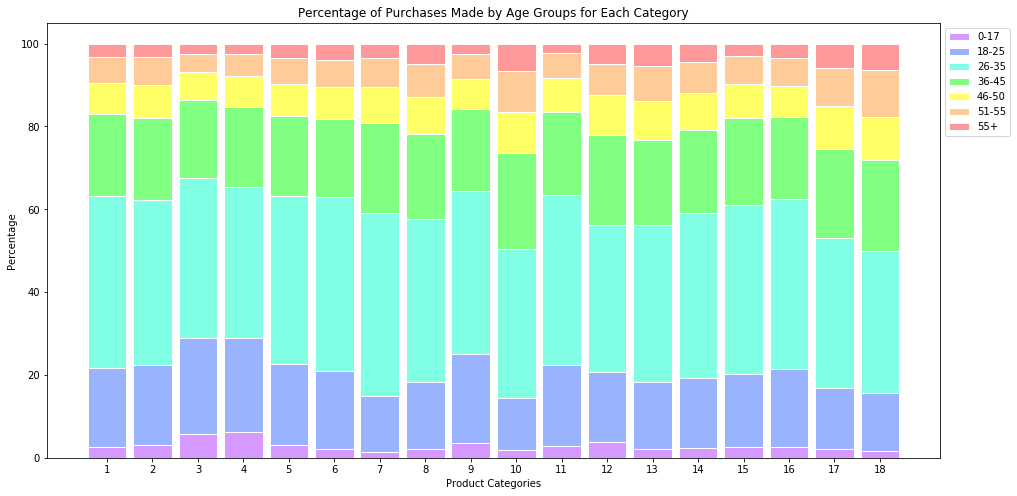

In [27]:
# From raw value to percentage
totals = age_count.sum(axis=1).values
age_17 = [i / j * 100 for i,j in zip(age_count['0-17'], totals)]
age18_25 = [i / j * 100 for i,j in zip(age_count['18-25'], totals)]
age26_35 = [i / j * 100 for i,j in zip(age_count['26-35'], totals)]
age36_45 = [i / j * 100 for i,j in zip(age_count['36-45'], totals)]
age46_50 = [i / j * 100 for i,j in zip(age_count['46-50'], totals)]
age51_55 = [i / j * 100 for i,j in zip(age_count['51-55'], totals)]
age55_ = [i / j * 100 for i,j in zip(age_count['55+'], totals)]

# plot
barWidth = 0.85
names = list(range(1,19))
r = list(range(0,18))

# Set size
fig = plt.figure()
fig.set_size_inches(16, 8)

# Create bars
plt.bar(r, age_17, color='#d699ff', edgecolor='white', width=barWidth)
plt.bar(r, age18_25, bottom=age_17, color='#99b3ff', edgecolor='white', width=barWidth)
plt.bar(r, age26_35, bottom=[i+j for i,j in zip(age_17,age18_25)], color='#80ffe5', edgecolor='white', width=barWidth)
plt.bar(r, age36_45, bottom=[i+j+k for i,j,k in zip(age_17,age18_25,age26_35)], color='#80ff80', edgecolor='white', width=barWidth)
plt.bar(r, age46_50, bottom=[i+j+k+l for i,j,k,l in zip(age_17,age18_25,age26_35,age36_45)], color='#ffff66', edgecolor='white', width=barWidth)
plt.bar(r, age51_55, bottom=[i+j+k+l+m for i,j,k,l,m in zip(age_17,age18_25,age26_35,age36_45,age46_50)], color='#ffcc99', edgecolor='white', width=barWidth)
plt.bar(r, age55_, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(age_17,age18_25,age26_35,age36_45,age46_50,age51_55)], color='#ff9999', edgecolor='white', width=barWidth)

# Add title and labels
plt.xticks(r, names)
plt.xlabel("Product Categories")
plt.ylabel("Percentage")
plt.title("Percentage of Purchases Made by Age Groups for Each Category")
plt.legend(age_column,loc=0, bbox_to_anchor=(1.0, 1.0))
# Show graphic
plt.show()

What an interesting find! As we have observed in previous graphs, the 26 to 35 age group was the overall biggest spender. However, as you can observe, they are not only the top spenders overall, they are the top spenders for every category. <br>
In the role of a retailer or advertising agency this information is invaluable. Not only does it tell us the age groups that spend the most across the board, 18 to 45, it shows us how little groups like 0 to 17 and 55+ spend. 

# <section id="hypothesis">Hypothesis testing for the mean of different groups of age</section>

Next, we are going to perform hypothesis testing on the mean purchase of male and female at significant level α = 0.05. <br>
Base on the previous observation, <br>
the <b>null hypothesis</b> is that mean purchase made by males and females are equal, and <br>
our <b>alternative hypothesis</b> is mean purchase made by males and females are different.

$
H_0 : μ_{male} = μ_{female} \\
H_1 : μ_{male} ≠ μ_{female} \\
α = 0.05
$

In [28]:
female_Purchase= blackfriday[blackfriday['Gender'] == 'F']['Purchase']
male_Purchase = blackfriday[blackfriday['Gender'] == 'M']['Purchase']
# Perform a standard independent 2 sample test that assumes equal population variances for male and female
print("2 sample test (assuming equal variance)")
f_val, p_val = stats.ttest_ind(male_Purchase, female_Purchase) 
print("F-statistic = ", f_val)
print("P-value = ", p_val)

2 sample test (assuming equal variance)
F-statistic =  44.13462293864972
P-value =  0.0


Because the p-value = 0.0 < α = 0.05, there is enough evidence to prove that mean purchases made by males is significantly different from purchases made by women.

In [29]:
# perform Welch’s t-test, which does not assume equal population variance 
print("Welch’s t-test")
f_val, p_val = stats.ttest_ind(male_Purchase, female_Purchase, equal_var=False) 
print("F-statistic = ", f_val)
print("P-value = ", p_val)

Welch’s t-test
F-statistic =  45.67264701908008
P-value =  0.0


Because the means are significantly different, we should expect the variance of these two population to also differ. <br>For different population variance, Welch's t-test will have a higher accuracy. <br>Result of Welch's t-test also indicates the population means are different since the p-value = 0.0 < α = 0.05.

# <section id="ANOVA">Analysis of Variance </section>

For three or more population means, performing three or more hypothesis testing separately with <b>null hypothesis</b> $H_0: μ_1 = μ_2 = ... = μ_n$ would increase the probability of <b>Type I Error</b> (rejection of a true null hypothesis) so that it could be much higher than the level of significant α. <br><br>
Instead of a 2 sample t-test,
<b>Analysis of Variance (ANOVA)</b> is an inferential method used to test the equality of three or more population means.

Using scipy.stats to perform 1-way ANOVA that tests the null hypothesis that two or more groups have the same population mean. 

In [30]:
age_17= blackfriday[blackfriday['Age'] == '0-17']['Purchase']
age18_25= blackfriday[blackfriday['Age'] == '18-25']['Purchase']
age26_35= blackfriday[blackfriday['Age'] == '26-35']['Purchase']
age36_45= blackfriday[blackfriday['Age'] == '36-45']['Purchase']
age46_50= blackfriday[blackfriday['Age'] == '46-50']['Purchase']
age51_55= blackfriday[blackfriday['Age'] == '51-55']['Purchase']
age55_= blackfriday[blackfriday['Age'] == '55+']['Purchase']

f_val, p_val = stats.f_oneway(age_17, age18_25, age26_35, age36_45, age46_50, age51_55, age55_) 
print("One-way ANOVA")
print("F-statistic = ", f_val)
print("P-value = ", p_val)

One-way ANOVA
F-statistic =  43.48718107271441
P-value =  1.9552104879020313e-53


Using Statsmodels to produce ANOVA table

In [31]:
model = ols('Purchase ~ Age', data=blackfriday).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print (anova_table)

                sum_sq        df          F        PR(>F)
Age       6.470585e+09       6.0  43.487181  1.955210e-53
Residual  1.333110e+13  537570.0        NaN           NaN


Sure enough, since the p-value is significantly small, we have enough statistical evidence to prove that the mean purchase of different age group is significantly different. 

# <section id="9">Linear Regression </section>

#### A simple linear regression of purchases : Purchases = B0 + B1 * Frequency

In [32]:
display(freq_purchase.head())
X = freq_purchase[['Freq']].values.reshape(-1, 1)
y = freq_purchase[['Purchase']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
display("Intercept: ", reg.intercept_, "Coefficient: ", reg.coef_)

,Product_ID,Freq,Purchase
0,265242,1858,13983325
1,110742,1591,26382569
2,25442,1586,27532426
3,112142,1539,23882624
4,57642,1430,22493690


'Intercept: '

array([-244185.19322591])

'Coefficient: '

array([[10832.34609059]])

Our linear model is Purchase = -244185.20 +  10832.35 * Frequency

In [33]:
y_pred = reg.predict(X_test)
y_pred

array([[5345305.38951792],
       [ 145779.26603529],
       [1683972.4108989 ],
       ...,
       [-222520.50104473],
       [ 828217.06974238],
       [ 286599.76521294]])

Let's plot this model's prediction

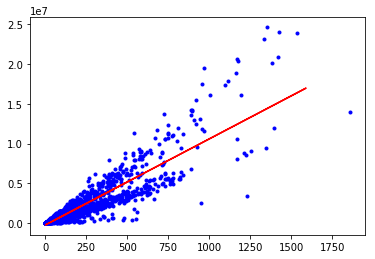

In [34]:
plt.plot(X_train, y_train, "b.")
plt.plot(X_test, y_pred, "r-")
plt.show()

<b>R-squared</b> is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. <a href="http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit">Read more</a> 
<br><br>
Most of the time if R-squared score is greater than 60% then it is good enough to use the model. Let's check out this model whether it is good or bad with R-squared.

In [35]:
reg.score(X_test, y_test)

0.835688539457739

It turns out that this r-squared score is very good. Most of the time, we can use this model to predict the new and unseen input. 

<b>Fit a multiple linear regression model for Purchase using Occupation and Age</b>
<br><br>
Since most of the variables in the dataset are categorical, it is necessary to convert these qualitative (characteristic) values to quantitative (numerical) values.

Occupations in the dataset are already represented as numbers so we just need to assign each age group a numeric value. From the 
Exploratory Data Analysis, we know the rank of the purchase power of each group, which is a numeric representation of each age group and can be used for the linear regression model.

In [36]:
numeric = blackfriday[['Age', 'Occupation', 'Purchase', 'Stay_In_Current_City_Years', 'Marital_Status']]
numeric = numeric.copy()

In [37]:
# Assign each age group a numeric value based on the rank of the amount of purchase
#     1 is assigned to Age group 26-35
#     2 is assigned to Age group 36-45
#     3 is assigned to Age group 18-25
#     4 is assigned to Age group 46-50
#     5 is assigned to Age group 51-55
#     6 is assigned to Age group 55+
#     7 is assigned to Age group 0-17 

for index, row in numeric.iterrows():
    if row['Age'] == '26-35':
        numeric.at[index, 'rank'] = 1
    elif row['Age'] == '36-45':
        numeric.at[index, 'rank'] = 2
    elif row['Age'] == '18-25':
        numeric.at[index, 'rank'] = 3
    elif row['Age'] == '46-50':
        numeric.at[index, 'rank'] = 4
    elif row['Age'] == '51-55':
        numeric.at[index, 'rank'] = 5
    elif row['Age'] == '55+':
        numeric.at[index, 'rank'] = 6
    elif row['Age'] == '0-17':
        numeric.at[index, 'rank'] = 7
numeric.head()

,Age,Occupation,Purchase,Stay_In_Current_City_Years,Marital_Status,rank
0,0-17,10,8370,2,0,7.0
1,0-17,10,15200,2,0,7.0
2,0-17,10,1422,2,0,7.0
3,0-17,10,1057,2,0,7.0
4,55+,16,7969,4,0,6.0


In [38]:
X = numeric[['Occupation', 'rank']]
y = numeric.Purchase
reg = linear_model.LinearRegression().fit(X, y)
X.head()

,Occupation,rank
0,10,7.0
1,10,7.0
2,10,7.0
3,10,7.0
4,16,6.0


In [39]:
est1 = sm.OLS(y, X).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                 4.330e+05
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        19:52:16   Log-Likelihood:            -5.4864e+06
No. Observations:              537577   AIC:                         1.097e+07
Df Residuals:                  537575   BIC:                         1.097e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Occupation   373.7333      1.145    326.332      0.0

The R-square indicates less than 0.0005 percent of the variance is explained by the linear regression model, which means the model is extremely inaccurate. The reason is very likely to be the lack of variables, especially numerical variables. Since the dataset naturally does not have sufficient numerical data, the only thing we can do to improve the model is to use more variables to construct the model.

Previous example demonstrated how to construct a multiple linear regression model with sklearn. We are going to use statsmodels to build another model with more variables to see if the accuracy could be improved.

In [40]:
model = ols(formula='Purchase ~ Occupation + rank + Stay_In_Current_City_Years + Marital_Status', data=numeric)
est2 = model.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     63.36
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           1.22e-53
Time:                        19:52:17   Log-Likelihood:            -5.3393e+06
No. Observations:              537577   AIC:                         1.068e+07
Df Residuals:                  537572   BIC:                         1.068e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Even though the model is still horrible, we do see the R-square is slightly improved. <br>Wrapping up in a sentence, building an accurate linear regression model requires sufficient numerical data.

# <section id="10">Logistic Regression </section>

<b>Classify Gender Given Occupation</b>

There is a challenge in our dataset which is imbalance between the number of male and female. The number of observations for female are only one third over male. Standard classifier algorithms like Logistic Regression has a bias towards classes which have number of instances. The tend to only predict the majority class. The features of minority are treated as noise and are often ignored. Thus there is a high probability of misclassification of the minority class as compared to the majority class.
<br><br>
There are several approaches to handle imbalance datasets: 
<br>
<ul>
    <li>Random Resampling</li>
    <li>Cluster-Based Over Sampling</li>
    <li>Informed Over Sampling: Synthetic Minority Over-sampling Technique</li>
    <li>Modified synthetic minority oversampling technique</li>
</ul>
<br>
In our case, I would like to try out the Random Resampling Approach. 

In [41]:
purchase_by_user = blackfriday.groupby(['User_ID', 'Gender', 'Occupation', 'Mean_age', 'Marital_Status']).agg({'Purchase': np.sum})
purchase_by_user.reset_index(inplace=True)
purchase_by_user.Gender = purchase_by_user.Gender.map({'F':0, 'M': 1})
purchase_by_user.head()

,User_ID,Gender,Occupation,Mean_age,Marital_Status,Purchase
0,1000001,0,10,8.5,0,333481
1,1000002,1,16,67.5,0,810353
2,1000003,1,15,30.5,0,341635
3,1000004,1,7,48.0,1,205987
4,1000005,1,20,30.5,1,821001


In [42]:
male = purchase_by_user[purchase_by_user.Gender==1] # Get all male 
female = purchase_by_user[purchase_by_user.Gender==0] # Get all female
male = male.head(int(len(male)/2)) # only need half of the male population
new_df = pd.concat([male, female, female]) # double the number of female population

In [43]:
X = new_df[['Occupation']].values.reshape(-1,1)
y = new_df['Gender'] #1 as Male, 0 as Female

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


### Compute precision, recall, F-measure and support
<br> Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

In [45]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.64      0.93      0.76      1003
          1       0.62      0.18      0.28       631

avg / total       0.64      0.64      0.58      1634



Precision: 64% female and 62% male selected instances are relevant.
<br> Recall: 93% female and only 18% male relevant instances are selected.

Now, let's try Bagging Classifier to see if the result is better than Logistic Regression

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000, max_samples=0.8, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
bag_clf.oob_score_

0.6587926509186351

According to this oob evaluation, this BaggingClassifier is likely to achieve about 65.9% accuracy on the test set. Let's verify this:

In [47]:
accuracy_score(y_test, y_pred)

0.6542227662178702

We get 65.4% accuracy on the test set. It is close enough.

### Compute precision, recall, F-measure and support

In [48]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.66      0.89      0.76      1003
          1       0.61      0.28      0.39       631

avg / total       0.64      0.65      0.61      1634



As we can see, the result is a little bit better than Logistic Regression. But there is a tradeoff when we use BaggingClassifier. The precision in female increases but the recall decreases. With male, the precision decreases while the recall increases. 
<br>
<br>Precision: 66% female and 61% male selected instances are relevant. 
<br>Recall: 89% female and only 28% male relevant instances are selected.

<b>Classify Marrital Status Given Mean Age</b>

In [49]:
X = purchase_by_user[['Mean_age']].values.reshape(-1,1)
y = purchase_by_user['Marital_Status']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67


### Compute precision, recall, F-measure and support

In [51]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.87      0.76      1032
          1       0.68      0.39      0.50       736

avg / total       0.67      0.67      0.65      1768



Now, let's try Bagging Classifier to see if the result is better than Logistic Regression

In [52]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=1000, max_samples=0.8, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
bag_clf.oob_score_

0.670870725200097

According to this oob evaluation, this BaggingClassifier is likely to achieve about 67.1% accuracy on the test set. Let's verify this:

In [53]:
accuracy_score(y_test, y_pred)

0.6702488687782805

We get 67.0% accuracy on the test set. It is close enough.

### Compute precision, recall, F-measure and support

In [54]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.87      0.76      1032
          1       0.68      0.39      0.50       736

avg / total       0.67      0.67      0.65      1768



# <section id="conclusion">Conclusion</section>

Black Friday is the biggest day of shopping in the year. The goal of our project was to take the dataset of Black Friday sales and use the techniques we learned throughout the semester to extract data that will help advertisers and retailers make the most of it. Using Exploratory data analysis, and regression  we saw  how attributes such as age, gender, marital status, and more affect the way one should expect people to shop that day. The result of this project will help retailers advertise to the right target groups for their products, leading to more happy purchases, resulting in a happier holiday season!

<img src="happy.jpg" width="900" height="600"/>